Time Series data has an input of consecutive days of features, based on the window. This is a project to predict the closing stock price of Apple Inc through various models.

In [2]:
!pip install yfinance
!pip install ta
!pip install tensorflow
!pip install --upgrade tensorflow

  Using cached ta-0.11.0-py3-none-any.whl


In [3]:
import pandas as pd
import ta
import numpy as np
import yfinance as yfin
import matplotlib.pyplot as plt
import matplotlib
import sklearn as sk
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import numpy as np

In [4]:
ticker = "AAPL"
df = yfin.download(ticker, start="2022-01-01", end="2025-01-01", interval="1d")
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
print(df.columns)

[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [5]:
# RSI: Measures whether a stock is overbought (>70) or oversold (<30) based on recent price changes
df['RSI'] = ta.momentum.rsi(df['Close'])
# MACD: Compares two EMAs (12-day and 26-day) to identify trend changes. A bullish signal occurs when MACD crosses above its signal line
df['MACD'] = ta.trend.macd(df['Close'])
# Stoch: Compares the closing price to the price range over a period. Values above 80 indicate overbought conditions, below 20 indicate oversold conditions
df['stoch'] = ta.momentum.stoch(df['High'], df['Low'], df['Close'])

# EMA 50 & EMA 200: Commonly used for trend confirmation (Golden Cross: EMA50 crosses above EMA200 = bullish)
df['EMA50'] = ta.trend.ema_indicator(df['Close'], window=50)
df['EMA200'] = ta.trend.ema_indicator(df['Close'], window=200)

# Upper Band (hband): Represents overbought conditions
df['BBupper'] = ta.volatility.bollinger_hband(df['Close'])
# Lower Band (lband): Represents oversold conditions
df['BBlower'] = ta.volatility.bollinger_lband(df['Close'])

# ADI: Shows how volume flows in and out of a stock. A rising ADI suggests strong buying pressure
df['ADI'] = ta.volume.acc_dist_index(df['High'], df['Low'], df['Close'], df['Volume'])
# OBV: Uses volume to predict price changes. If OBV rises with price, the trend is strong
df['OBV'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])

# 1 Day Return: Measures the percentage change in price from the previous day
df['1Dreturn'] = df['Close'].pct_change(1)
# 7 Day Return: Measures the percentage change over the past 7 days
df['7Dreturn'] = df['Close'].pct_change(7)

# Getting error because lots of NAN values, so RSI, MACD, EMAs weren't getting calculated because there was less than the minimum data needed
# Add the data by using forward fill
df.dropna(inplace=True)
df.fillna(method='ffill', inplace=True)

<ipython-input-5-fcb5c82eb885>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [6]:
print(df.head())

                 Close        High         Low        Open    Volume  \
Date                                                                   
2022-10-18  142.018463  144.932926  138.916287  143.737509  99136600   
2022-10-19  142.127151  143.204018  139.795578  139.983292  61758300   
2022-10-20  141.662781  144.132667  140.931689  141.297242  64522000   
2022-10-21  145.496048  146.069063  140.931688  141.149040  86548600   
2022-10-24  147.649811  148.420414  144.241370  145.417039  75981900   

                  RSI      MACD      stoch       EMA50      EMA200  \
Date                                                                 
2022-10-18  45.737768 -3.712699  71.222450  148.382883  156.172617   
2022-10-19  45.906643 -3.351121  72.057782  148.137560  156.032861   
2022-10-20  45.258554 -3.066688  68.488827  147.883647  155.889875   
2022-10-21  51.362605 -2.503105  95.697318  147.790016  155.786454   
2022-10-24  54.436787 -1.861217  95.081982  147.784517  155.705492   

    

In [7]:
# Train-Test Split

test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(df))
test_size = int(test_ratio * len(df))
print(f"train_size: {train_size}")
print(f"test_size: {test_size}")

train = df[:train_size][["Close"]]
test = df[train_size:][["Close"]]

train_size: 443
test_size: 110


In [8]:
# Split time-series into X and Y based on a window size
def extract_seqX_outcomeY(data, N, offset):
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i - N : i])
        y.append(data[i])

    return np.array(X), np.array(y)

In [9]:
# Evaluation metrics: RMSE and MAPE
def calculate_rmse(y_true, y_pred):
    rmse = np.sqrt(np.nanmean((y_true - y_pred) ** 2))
    return rmse

def calculate_mape(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mask = np.logical_and(np.isfinite(y_true), y_true != 0)
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return mape

In [10]:
# Calculate performance metrics of RMSE and MAPE

def calculate_perf_metrics(var):

    close_values = np.array(df[train_size:]["Close"])
    var_values = np.array(df[train_size:][var])
    mask = np.logical_and(np.isfinite(close_values), np.isfinite(var_values))

    rmse = calculate_rmse(close_values[mask], var_values[mask])
    mape = calculate_mape(close_values[mask], var_values[mask])

    return rmse, mape

In [11]:
from typing import Optional
# Plot the stock

def plot_stock_trend(var, cur_title, df=df):
      #ax = df[["Close", var, Optional[var]]].plot(figsize=(20, 10))
      ax = df[["Close", var]].plot(figsize=(20, 10))
      plt.grid(False)
      plt.title(cur_title)
      plt.axis("tight")
      plt.ylabel("Stock Price ($)")

Since the EMA 200 is below the stock price, this means that the stock is in good shape and in an upward trend (obviously, this is Apple). The steeper the slope, the more positive of an upward trend. Apple being a larger and most historical stock is less likely to have drastic upward trend, but rather consistent increase.

While I know that Long short-term Memory is good for time-series data (learns the important parts of a sequence), I also want to use Moving Average technique which finds the average closing price over a period and Simple MA to find the range of stock closing prices over a time period. There is also Exponential MA that weights recent data higher than historical data. I'll use all of these and compare them through the performance metrics of RMSE and MAPE.

200 Day SMA, RMSE: 31.511966137056305, MAPE: 13.356028947677922


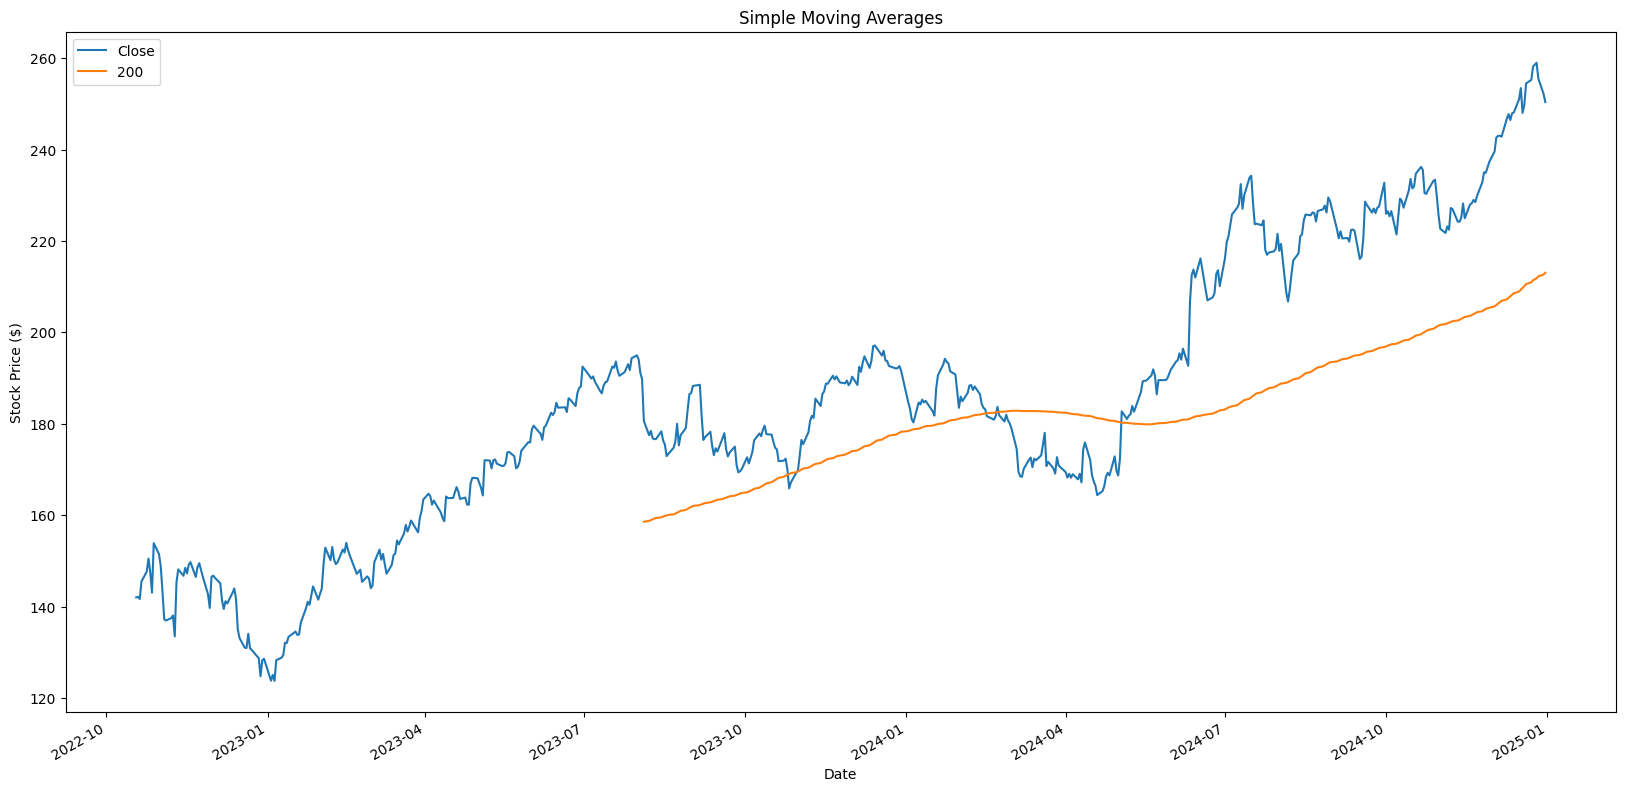

In [12]:
# 200 Day Simple Moving Average
window = 200

df[window] = df["Close"].rolling(window).mean()
plot_stock_trend(window, "Simple Moving Averages", df)
rmse_sma, mape_sma = calculate_perf_metrics(var=window)
print(f"200 Day SMA, RMSE: {rmse_sma}, MAPE: {mape_sma}")

The 200 SMA is pretty far off the actual values. Although it's the more popular one, ill also try it with a 50 day SMA.

50 Day SMA, RMSE: 8.830294594971711, MAPE: 2.9656868348760113


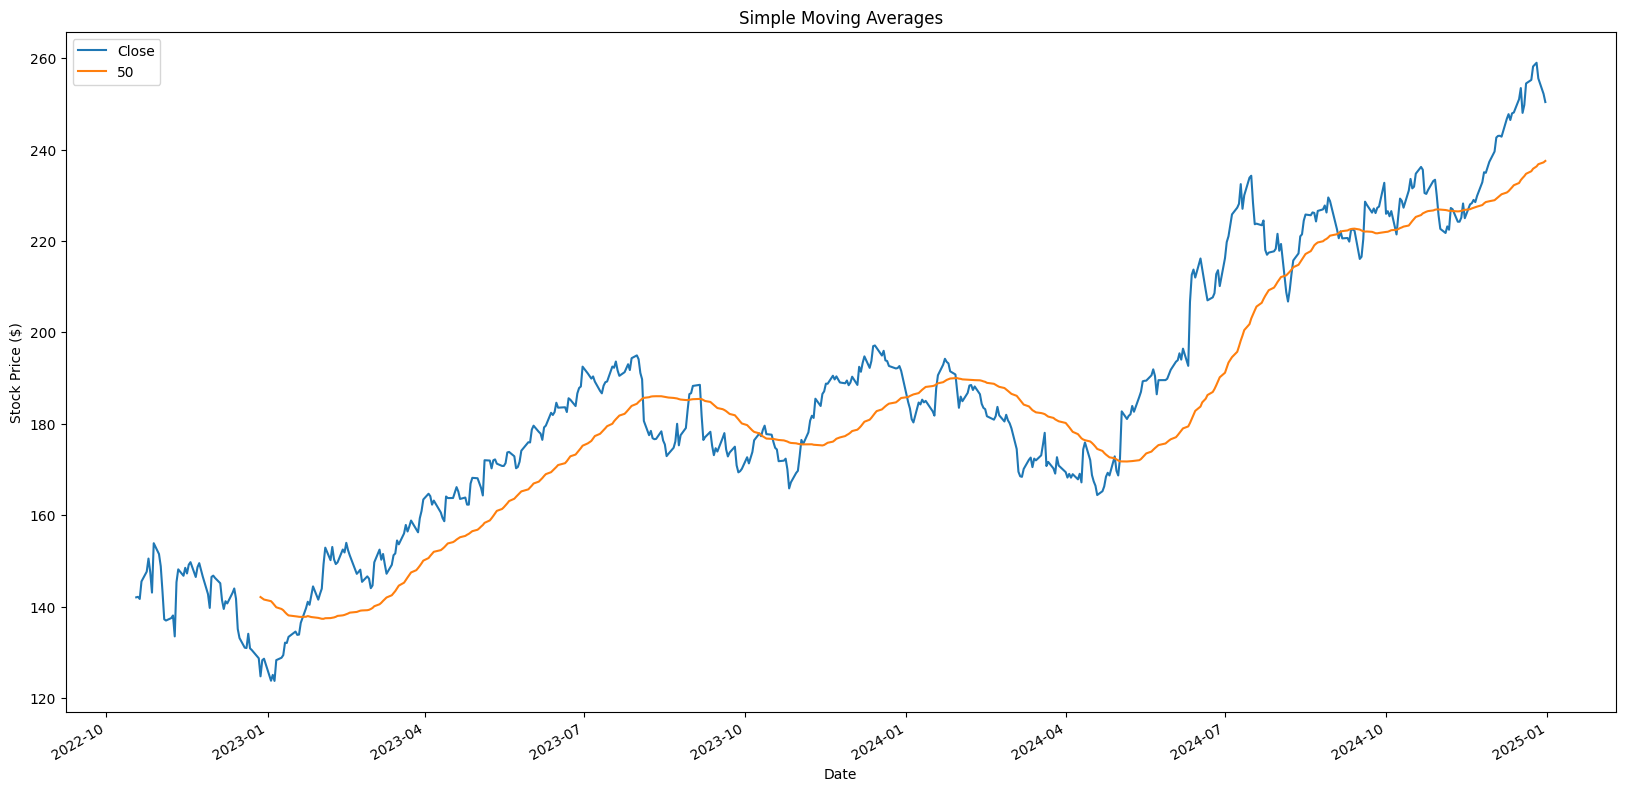

In [13]:
window = 50

df[window] = df["Close"].rolling(window).mean()
plot_stock_trend(window, "Simple Moving Averages", df)
rmse_sma, mape_sma = calculate_perf_metrics(var=window)
print(f"50 Day SMA, RMSE: {rmse_sma}, MAPE: {mape_sma}")

The 50 day SMA is a lot more accurate than the 200 SMA, which is interesting because I read that a lot of amateur daytraders use 200 SMA

50 Day EMA, RMSE: 8.870568426190092, MAPE: 3.1666772907142633
200 Day EMA, RMSE: 26.650640656333266, MAPE: 11.203973095652861


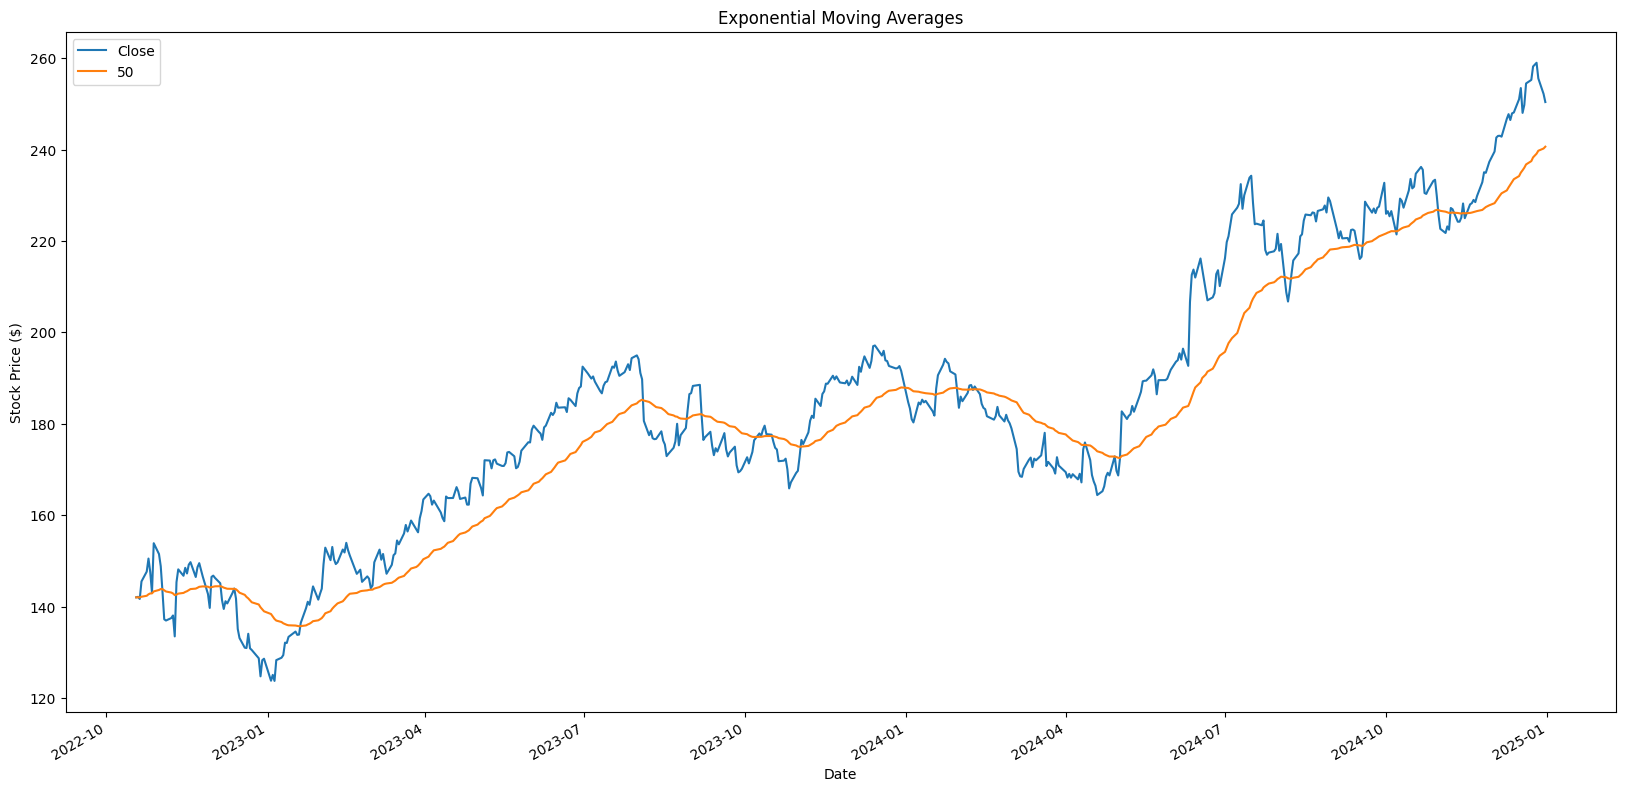

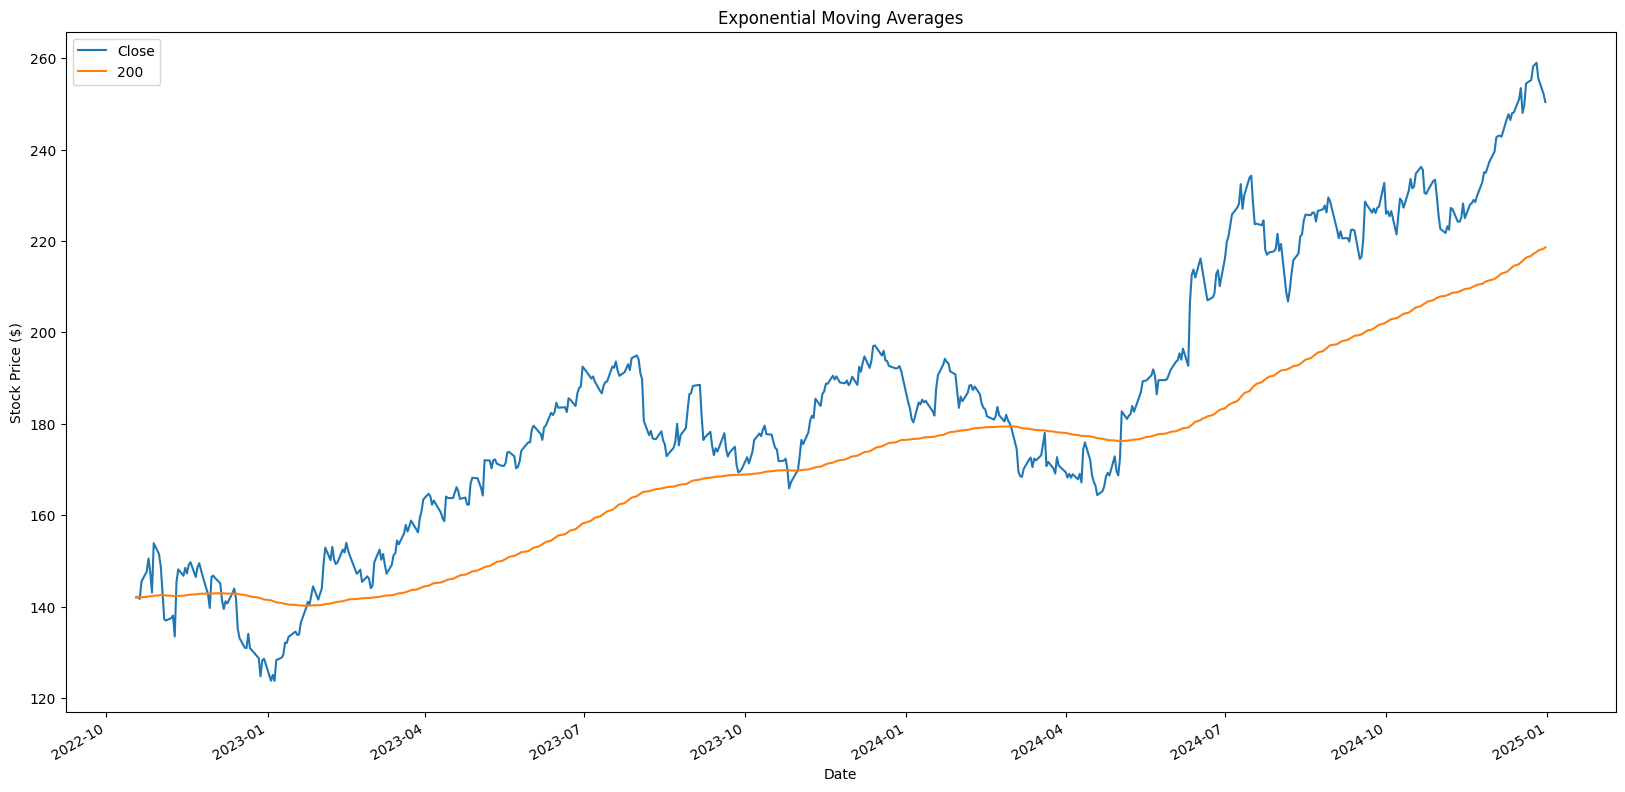

In [14]:
# Exponential MA
window = 50
df[window] = (
    df["Close"].ewm(span=window, adjust=False).mean()
)
plot_stock_trend(
    var=window, cur_title="Exponential Moving Averages")
rmse_ema, mape_ema = calculate_perf_metrics(var=window)
print(f"50 Day EMA, RMSE: {rmse_ema}, MAPE: {mape_ema}")

window = 200
df[window] = (
    df["Close"].ewm(span=window, adjust=False).mean()
)
plot_stock_trend(
    var=window, cur_title="Exponential Moving Averages")
rmse_ema2, mape_ema2 = calculate_perf_metrics(var=window)
print(f"200 Day EMA, RMSE: {rmse_ema2}, MAPE: {mape_ema2}")

In cases for both the EMA and SMA, the 50 day performed better based on evaluation metrics compared to the 200 day. This means that something like the  would also perform really well because it would consider the recent information more important. Similar to how EMA weights it.

In [15]:
"""# LSTM model and hyperparameters

def LSTM_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=layer_units, input_shape=input_shape))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Adaptive Movement Optimizer is good for noisy data
layer_units = 50
optimizer = "adam"
cur_epochs = 15
cur_batch_size = 20

# 50 day window has been the best so far
window = 50

# Normalize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[["Close"]])
scaled_data_train = scaled_data[:train.shape[0]]


# 50 - 200 epochs with early stop to prevent overfitting
# Window of 50 days
# Dropout of 0.3 to regularize data
# Default Adam learning rate
# Medium sized LSTM units to prevent overfitting

from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import L1L2


features = ['RSI', 'MACD', 'stoch', 'EMA50', 'EMA200', 'BBupper', 'BBlower', 'ADI', 'OBV', '1Dreturn', '7Dreturn']
target = df['Close']


model = Sequential([
    LSTM(128, return_sequences=True,
         input_shape=(window, len(features)),
         kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)),
    Dropout(0.4),
    LSTM(32, kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)),
    Dropout(0.2),
    Dense(1)
])



# Time series split instead of regulat Train-Test
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_target = target.values.reshape(-1, 1)


# Create time series sequence
def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)



X, y = create_sequences(scaled_features, scaled_target, window)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    clipvalue=0.5 # manage how aggresive the gradient is
)

model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test), shuffle=False, callbacks=[early_stop])

"""


'# LSTM model and hyperparameters\n\ndef LSTM_model(input_shape):\n    model = Sequential()\n    model.add(LSTM(units=layer_units, input_shape=input_shape))\n    model.add(Dense(1))  # Output layer for regression\n    model.compile(optimizer=optimizer, loss=\'mean_squared_error\')\n    return model\n\n# Adaptive Movement Optimizer is good for noisy data\nlayer_units = 50\noptimizer = "adam"\ncur_epochs = 15\ncur_batch_size = 20\n\n# 50 day window has been the best so far\nwindow = 50\n\n# Normalize\nscaler = StandardScaler()\nscaled_data = scaler.fit_transform(df[["Close"]])\nscaled_data_train = scaled_data[:train.shape[0]]\n\n\n# 50 - 200 epochs with early stop to prevent overfitting\n# Window of 50 days\n# Dropout of 0.3 to regularize data\n# Default Adam learning rate\n# Medium sized LSTM units to prevent overfitting \n\nfrom tensorflow.keras.layers import Dropout\nfrom tensorflow.keras.regularizers import L1L2\n\n\nfeatures = [\'RSI\', \'MACD\', \'stoch\', \'EMA50\', \'EMA200\', \'

LSTMs are recurrent NNs that remember patterns over long sequences and can handle noisy data. First the data needs to be cleaned and create any neccessary new features. I've already done that earlier. Then it needs to be scaled because LSTMs are sensitive. Based on what I've read, StandardScaler is better than a MinMaxScaler for LSTMs. Sequencing means converting the data into a sort of sliding window. Converting the time-series data into input-output pairs that the LSTM can understand. If the window is too small it misses important information and if it's too large there is a lot of unneccessary data.

In [57]:
# Process: Clean Data -> Feature Engineering -> Scale -> Time Series Sequence -> Train -> Predict

df.dropna(inplace=True)
df.head()

#features = ['RSI', 'MACD', 'stoch', 'EMA50', 'EMA200', 'BBupper', 'BBlower', 'ADI', 'OBV', '1Dreturn', '7Dreturn']
#features = ['RSI', 'MACD', 'EMA50', 'ADI', '7Dreturn', 'OBV']
features = ['RSI', 'MACD', 'EMA50', 'ADI', 'OBV']

target = 'Close'
X = df[features].values
y = df[target].values.reshape(-1, 1)

# Time Series scaling
x_scale = StandardScaler()
y_scale = StandardScaler()

train_size = int(len(df) * 0.7)
test_size = len(df) - train_size

X_unscaled = X[:train_size]
y_unscaled = y[:train_size]

X_scaled = x_scale.fit_transform(X_unscaled)
y_scaled = y_scale.fit_transform(y_unscaled)

X_test_scaled = x_scale.transform(X[train_size:])
y_test_scaled = y_scale.transform(y[train_size:])


# Sequence
window = 50
X_train = np.array([X_scaled[i:i+window] for i in range(len(X_scaled) - window)])
y_train = np.array([y_scaled[i+window] for i in range(len(y_scaled) - window)])

X_test = np.array([X_test_scaled[i:i+window] for i in range(len(X_test_scaled) - window)])
y_test = np.array([y_test_scaled[i+window] for i in range(len(y_test_scaled) - window)])


# LSTM Model

shape = (window, len(features))

"""model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False, input_shape = shape), tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1)
    ])"""

"""model = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.05, input_shape=(window, len(features))),
    tf.keras.layers.LSTM(24,
                       activation='tanh',
                       recurrent_dropout=0.2,
                       kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])"""


model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32,
                     input_shape=shape,
                     recurrent_dropout=0.3,
                     kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
])


"""model = tf.keras.Sequential([
    tf.keras.layers.LSTM(20,
                     input_shape=(window, len(features)),
                     dropout=0.1,
                     recurrent_dropout=0.3,
                     kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])"""


# Clipnorm to manage gradient
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=0.7)

model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    mode='min',
    restore_best_weights=True
)

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.3,
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 32)                  │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - loss: 1.0941 - root_mean_squared_error: 1.0208 - val_loss: 0.3153 - val_root_mean_squared_error: 0.5435
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.6000 - root_mean_squared_error: 0.7547 - val_loss: 0.1843 - val_root_mean_squared_error: 0.4055
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5334 - root_mean_squared_error: 0.7057 - val_loss: 0.1078 - val_root_mean_squared_error: 0.2968
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.3109 - root_mean_squared_error: 0.5345 - val_loss: 0.0804 - val_root_mean_squared_error: 0.2465
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2531 - root_mean_squared_error: 0.4787 - val_loss: 0.0801 - val_root_mean_squared_error: 0.2461
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2303 - root_mean_squared_error: 0.4562 - val_loss: 0.0780 - val_root_mean_squared_error: 0.2422
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.202

In [58]:
# Predicting

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Revert to unscaled units
y_train_actual = y_scale.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = y_scale.inverse_transform(y_test.reshape(-1, 1)).flatten()
train_pred_actual = y_scale.inverse_transform(train_pred.reshape(-1, 1)).flatten()
test_pred_actual = y_scale.inverse_transform(test_pred.reshape(-1, 1)).flatten()

train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_pred_actual))
train_mape = np.mean(np.abs((y_train_actual - train_pred_actual) / (y_train_actual + 1e-10))) * 100

test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred_actual))
test_mape = np.mean(np.abs((y_test_actual - test_pred_actual) / (y_test_actual + 1e-10))) * 100

print("\nTraining Metrics:")
print(f"RMSE: ${train_rmse:.2f}")
print(f"MAPE: {train_mape:.2f}%")

print("\nTest Metrics:")
print(f"RMSE: ${test_rmse:.2f}")
print(f"MAPE: {test_mape:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Training Metrics:
RMSE: $4.42
MAPE: 2.06%

Test Metrics:
RMSE: $38.86
MAPE: 16.26%


I've worked on just tweaking the LSTM model for over three days, and haven't found a way to prevent the model from overfitting on the training set. Tweaking all of the hyperparameters, introducing clipnorm, changing the hidden layer types and creating an earlystop conditional didn't solve the problem. Maybe I'll come back to it later, but I can't seem to figure out how to prevent the overfitting.

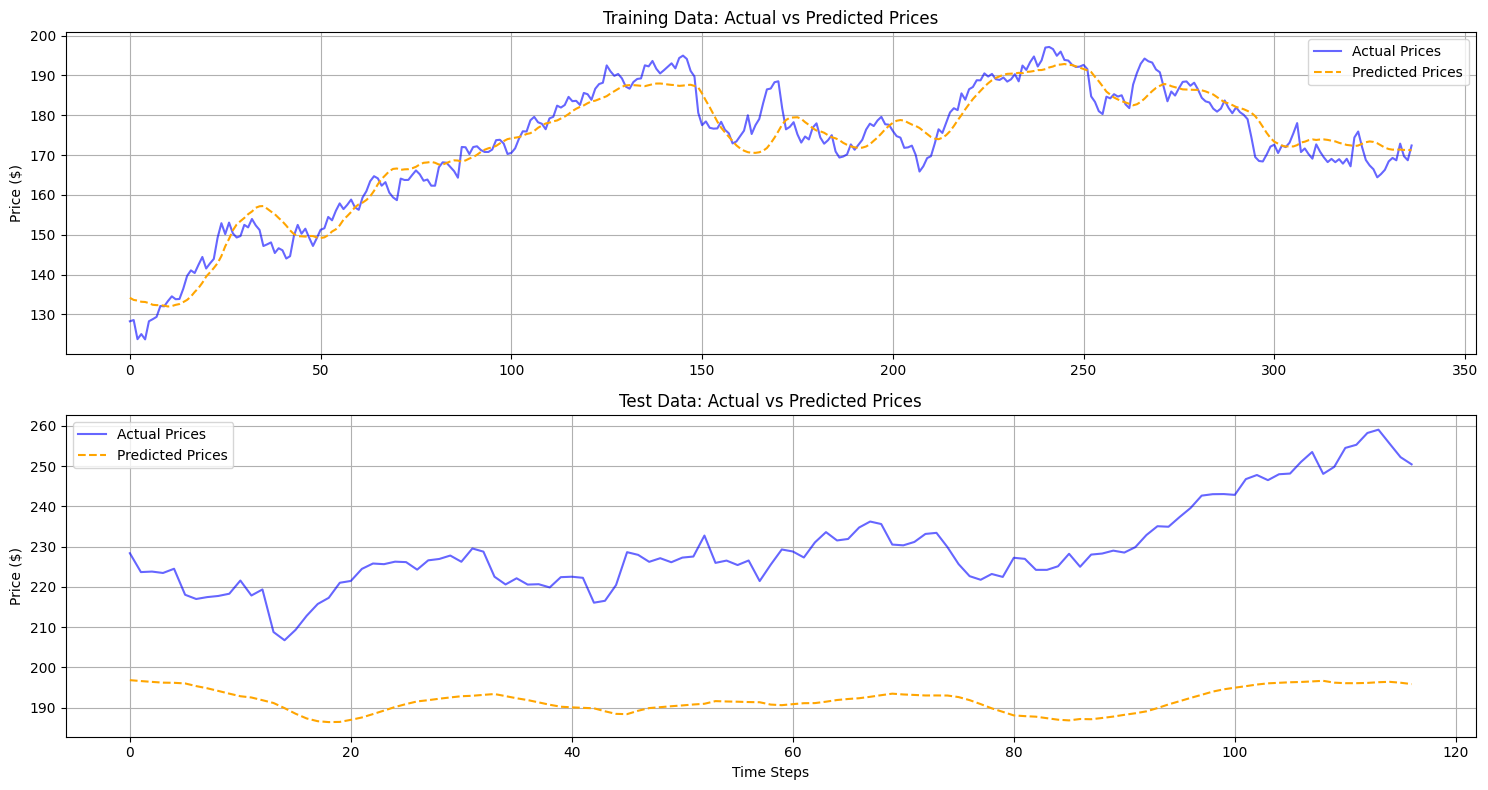

In [60]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(y_train_actual, label='Actual Prices', color='blue', alpha=0.6)
plt.plot(train_pred_actual, label='Predicted Prices', color='orange', linestyle='--')
plt.title('Training Data: Actual vs Predicted Prices')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y_test_actual, label='Actual Prices', color='blue', alpha=0.6)
plt.plot(test_pred_actual, label='Predicted Prices', color='orange', linestyle='--')
plt.title('Test Data: Actual vs Predicted Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time Steps')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()